In [1]:
from utils import *

NOTEBOOK_ID = '19'
CALCULATE_OVERLAP = False
CALCULATE_SIMILARITY = False

ModuleNotFoundError: No module named 'utils'

/tmp/ipykernel_2215587/2482533755.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = g.figure.colorbar(sm, label='Overlap (>10 residues)')


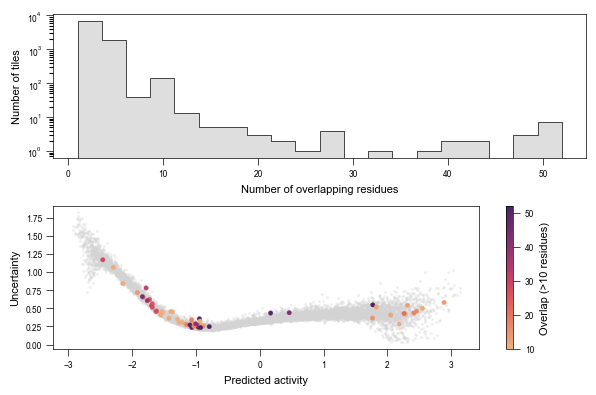

In [ ]:
if CALCULATE_OVERLAP:
    df = pd.read_csv(f'{LIBRARY_DIR}/mycocosm_test_codonoptimized.csv')
    overlaps = compute_overlap_matrix(df['seq'].to_list())
    np.save(f'{COMPARE_DIR}/mycocosm_overlaps.npz',overlaps)
else:
    df = pd.read_csv(f'{LIBRARY_DIR}/mycocosm_test_codonoptimized.csv')
    overlaps = np.load(f'{COMPARE_DIR}/mycocosm_overlaps.npz')
df['max_overlap'] = overlaps.max(axis=1)

fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(6,4))
g = sns.histplot(data=overlaps.max(axis=1),bins=20,element='step',color='lightgrey',linewidth=0.5,edgecolor='black',ax=axes[0])
g.set(yscale='log',xlabel='Number of overlapping residues',ylabel='Number of tiles')

g = sns.scatterplot(data=df.query('max_overlap <= 10'),x='predictions',y='uncertainty',edgecolor=None,s=3,color='lightgray',alpha=0.4)
g = sns.scatterplot(data=df.query('max_overlap > 10'),x='predictions',y='uncertainty',hue='max_overlap',s=10,edgecolor=None,palette=sns.color_palette('flare',as_cmap=True),legend=False)

g.set(xlabel='Predicted activity',ylabel='Uncertainty')

norm = plt.Normalize(10, df['max_overlap'].max())
sm = plt.cm.ScalarMappable(cmap='flare', norm=norm)
sm.set_array([])
colorbar = g.figure.colorbar(sm, label='Overlap (>10 residues)')
colorbar.ax.tick_params(width=0.5)
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-mycocosm_overlap.png',dpi=400,bbox_inches='tight',transparent=False)

In [2]:
len_dict = {}
for faa_file in glob(f'{COMPARE_DIR}/*dedup.faa'):
    handle = faa_file.split('/')[-1].replace('.faa','').replace('_dedup','')
    total_seqs = count_fasta_sequences(faa_file)
    len_dict[handle] = total_seqs
len_dict

NameError: name 'glob' is not defined

In [ ]:
if CALCULATE_SIMILARITY:
    data = []
    for faa_file in glob(f'{COMPARE_DIR}/*dedup.faa'):
        handle = faa_file.split('/')[-1].replace('.faa','')
        total_seqs = count_fasta_sequences(faa_file)
        data.append([handle,1.0,total_seqs,1.0])
        for threshold in np.arange(1.0, 0.63, -0.01):
            threshold = round(threshold,2)
            os.system(f'cd-hit -i {faa_file} -o {COMPARE_DIR}/clustered_{handle}_{threshold}.faa -c {threshold}')
            seqs = count_fasta_sequences(f'{COMPARE_DIR}/clustered_{handle}_{threshold}.faa')
            data.append([handle,threshold,seqs,seqs/total_seqs])
    similarity_df = pd.DataFrame(data,columns=['dataset','threshold','num_seqs','norm_count'])
    similarity_df['dataset'] = similarity_df['dataset'].apply(lambda x: x.replace('_dedup',''))
    similarity_df['dataset'] = similarity_df['dataset'].map({'mycocosm':f'MycoCosm test (n = {len_dict["mycocosm"]:,})', 
                                                             'morffy':f'Morffy et al. (n = {len_dict["morffy"]:,})',
                                                             'harmonized':f'harmonized (n = {len_dict["harmonized"]:,})',
                                                             'sanborn':f'Sanborn et al. (n = {len_dict["sanborn"]:,})'})
    similarity_df.to_csv(f'{COMPARE_DIR}/similarity_df.csv',index=False)
else:
    similarity_df = pd.read_csv(f'{COMPARE_DIR}/similarity_df.csv')

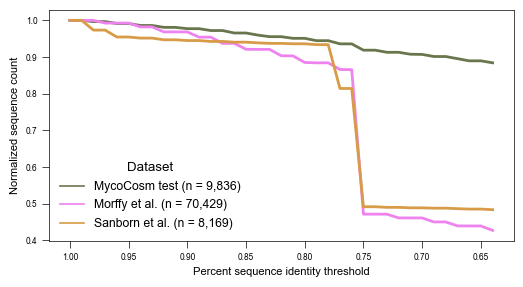

In [82]:
plt.figure(figsize=(6,3))
g = sns.lineplot(data=similarity_df.query('dataset != "harmonized (n = 25,660)"'),x='threshold',y='norm_count',hue='dataset',palette=['#69764d','violet','#d89b47'],linewidth=2)
g.legend(title='Dataset',frameon=False)
plt.gca().invert_xaxis()
g.set(xlabel='Percent sequence identity threshold',ylabel='Normalized sequence count')

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-sequence_identity_clustering.png',dpi=400,transparent=False,bbox_inches='tight')

# entropy

In [ ]:
# import datasets
morffy_seqs = pd.read_csv(f'{MORFFY_DIR}/01-dataset/TrainingsData.csv').drop_duplicates(subset='Sequence')
morffy_seqs = list(morffy_seqs[morffy_seqs['Sequence'].apply(lambda x: len(x) == 40)].rename(columns={'Sequence':'AAseq'})['AAseq'])

seq_dict = {
    'hummel':list(pd.read_csv(f'{TARGET_DIR}/01-dataset/hummel_preprocessed_Activity_500k_Rat.csv')[['AAseq','Activity_500k_Rat']].rename(columns={'Activity_500k_Rat':'old_activity'}).drop_duplicates(subset='AAseq')['AAseq']),
    'sanborn':list(pd.read_csv(f'{DATASET_DIR}/02-sanborn/all_paddle_data.csv').drop_duplicates(subset='protein sequence')['protein sequence']),
    'mycocosm':list(pd.read_csv(f'{LIBRARY_DIR}/library_optimized.csv').drop_duplicates('aa_seq')['aa_seq']),
    'harmonized':list(pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"').drop_duplicates(subset='AAseq')['AAseq']),
    'morffy':morffy_seqs
}

morffy_activities = pd.read_csv(f'{MORFFY_DIR}/01-dataset/TrainingsData.csv').drop_duplicates(subset='Sequence')
morffy_activities = morffy_activities[morffy_activities['Sequence'].apply(lambda x: len(x) == 40)].rename(columns={'Sequence':'AAseq'})['Score'].to_numpy()

activity_dict = {
    'hummel':pd.read_csv(f'{TARGET_DIR}/01-dataset/hummel_preprocessed_Activity_500k_Rat.csv')[['AAseq','Activity_500k_Rat']].rename(columns={'Activity_500k_Rat':'old_activity'}).drop_duplicates(subset='AAseq')['old_activity'].to_numpy(),
    'sanborn':pd.read_csv(f'{DATASET_DIR}/02-sanborn/all_paddle_data.csv').drop_duplicates(subset='protein sequence')['activation'].to_numpy(),
    'harmonized':pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"').drop_duplicates(subset='AAseq')['linear_harmonized_activity'].to_numpy(),
    'morffy':morffy_activities
}

NameError: name 'MORFFY_DIR' is not defined

In [ ]:
entropy_dict = {}
for dataset_name, dataset_seqs in seq_dict.items():
    entropy_dict[dataset_name] = (calculate_positional_entropy(dataset_seqs) / len(dataset_seqs[0]))
entropy_dict

{'hummel': 4.030330510844365,
 'sanborn': 4.116076873278811,
 'mycocosm': 4.137074162881748,
 'harmonized': 4.1141486604714075,
 'morffy': 4.180521284302979}

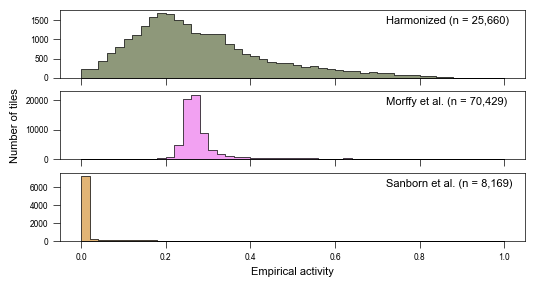

In [ ]:
scaled_activity_dict = {}
for dataset_name, dataset_activites in activity_dict.items():
    scaled_activity = preprocessing.StandardScaler().fit_transform(dataset_activites.reshape(-1,1))
    scaled_activity = preprocessing.MinMaxScaler().fit_transform(scaled_activity).reshape(-1)
    scaled_activity_dict[dataset_name] = scaled_activity
    
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(6,3),sharex=True)

tmp_df = pd.DataFrame([scaled_activity_dict]).T.explode(0).reset_index()
tmp_df.columns = ['dataset','scaled_activity']
g = sns.histplot(data=tmp_df.query('dataset=="harmonized"'),x='scaled_activity',ax=axes[0],element='step',bins=50,color='#69764d',edgecolor='black',linewidth=0.5)
g.set(ylabel=None)
ymin,ymax=g.get_ylim()
g.text(x=0.7,y=0.8,s=f'Harmonized (n = {len_dict["harmonized"]:,})',transform=g.transAxes)
g = sns.histplot(data=tmp_df.query('dataset=="morffy"'),x='scaled_activity',ax=axes[1],element='step',bins=50,color='violet',edgecolor='black',linewidth=0.5)
g.set(ylabel='Number of tiles')
g.text(x=0.7,y=0.8,s=f'Morffy et al. (n = {len_dict["morffy"]:,})',transform=g.transAxes)
g = sns.histplot(data=tmp_df.query('dataset=="sanborn"'),x='scaled_activity',ax=axes[2],element='step',bins=50,color='#d89b47',edgecolor='black',linewidth=0.5)
g.set(ylabel=None,xlabel='Empirical activity')
g.text(x=0.7,y=0.8,s=f'Sanborn et al. (n = {len_dict["sanborn"]:,})',transform=g.transAxes);
# g.set(yscale='log');
